In [1]:
## reference https://huggingface.co/learn/nlp-course/en/chapter7/6?fw=pt#training-a-causal-language-model-from-scratch

In [2]:
#installing some libraries
#!pip install datasets
!pip install --upgrade jupyter ipywidgets



Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch, transformers
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from transformers import PreTrainedModel, PretrainedConfig
from transformers import AutoModel, AutoConfig,AutoModelForCausalLM, AutoConfig,GPT2Config,GPT2Tokenizer
import torch.nn as nn
import torch.nn.functional as F
#from datasets import load_dataset
import pandas as pd, numpy as np
from torch.cuda.amp import autocast
from torch import cuda
import datetime
import warnings,itertools
from torch.optim.lr_scheduler import LambdaLR
import json
# Ignore all warnings
warnings.filterwarnings('ignore')
#pip install transformers bitsandbytes>=0.39.0 -q
import zipfile,logging

In [4]:
import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet
import random
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
#global params for training

B,T = 32,1024
epoch = 100
random_init_wts = True
min_text_len = 0
# hard coded com
comp_ratio = 3
# train_loss_list = []
# val_loss_list =[]
if cuda.is_available():
    device = torch.device('cuda:0')
    print(device)
else:
    device = 'cpu'
#print(device)
import os
os.environ["TOKENIZERS_PARALLELISM"] = "true"
#os.environ["MKL_DEBUG_CPU_TYPE"] = "5"

#print(global_tr_loss)
model_path = os.path.join("model")
print(model_path)

cuda:0
model


In [6]:
directory = os.path.join('.','data','unzip_text_10M')  # Replace with your directory path
directory

'./data/unzip_text_10M'

In [7]:
def read_text(directory):
    directory = os.path.join('.','data','unzip_text_10M',str(directory))  # Replace with your directory path
    print(f"directory :{directory}")
    # List all files in the directory
    files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    print(f"files:{files}")
    text_content = []
    # Read each file
    total_lines = 0
    for filenum,filename in enumerate(files):
        file_path = os.path.join(directory, filename)
        with open(file_path, 'r', encoding='utf-8') as file:
            #first_line = file.read()
            #print(f"filename :{filename}->first few lines {first_line}")
            #continue
            #lines_list = [line.strip() for line in open(file_path, 'r')]
            text = file.read()
            text_content.append(text)
            print(f"the file:{filename} has been appeneded to the uber list and its length is {len(text_content)} ")
            #total_lines+=len(lines_list)
            #text_content.append(lines_list)
    
    flattened_list = ''.join(text_content)
    assert (len(flattened_list) == total_lines , f"Expected {len(flattened_list)} to be equal to {total_lines}" )
    
    return flattened_list

    

In [8]:
train_list = read_text("train_10M")
#print(train_dict)
#val_list = read_text("dev")

directory :./data/unzip_text_10M/train_10M
files:['switchboard.train', 'simple_wiki.train', 'open_subtitles.train', 'gutenberg.train', 'childes.train', 'bnc_spoken.train']
the file:switchboard.train has been appeneded to the uber list and its length is 1 
the file:simple_wiki.train has been appeneded to the uber list and its length is 2 
the file:open_subtitles.train has been appeneded to the uber list and its length is 3 
the file:gutenberg.train has been appeneded to the uber list and its length is 4 
the file:childes.train has been appeneded to the uber list and its length is 5 
the file:bnc_spoken.train has been appeneded to the uber list and its length is 6 


In [9]:
len(train_list)

54215049

In [10]:
chunks = len(train_list)//(B*T)
print(chunks)

1654


In [11]:
tokenizer = GPT2Tokenizer.from_pretrained("distilgpt2")
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})


In [12]:
print(tokenizer.pad_token_id)

50257


In [13]:
val_list = read_text("dev")


directory :./data/unzip_text_10M/dev
files:['switchboard.dev', 'simple_wiki.dev', 'open_subtitles.dev', 'gutenberg.dev', 'childes.dev', 'bnc_spoken.dev']
the file:switchboard.dev has been appeneded to the uber list and its length is 1 
the file:simple_wiki.dev has been appeneded to the uber list and its length is 2 
the file:open_subtitles.dev has been appeneded to the uber list and its length is 3 
the file:gutenberg.dev has been appeneded to the uber list and its length is 4 
the file:childes.dev has been appeneded to the uber list and its length is 5 
the file:bnc_spoken.dev has been appeneded to the uber list and its length is 6 


In [14]:
print(tokenizer.eos_token_id)

50256


In [15]:
random.random()

0.6033372386529069

In [16]:
text = train_list[500:750]

In [17]:
text

'aska.\nA:\tI like to hunt,\nA:\tand, uh, so, I thought that if I had a good hunting dog like Thumper that, boy, I could just go out and get all kinds of game\nB:\tDid it work?\nA:\tYeah,\nA:\texcept we live in Plano, Texas now\nB:\tNo,\nB:\tright.\nA:\tso\nB:\tI, um, '

In [18]:
def get_df_from_list(text_list , B= B, T = T, val= False):
    chunk_size = B*T*comp_ratio
        
    # Step 3: Split the list into chunks and pad the last chunk if necessary
    chunks_inp = [text_list[i:i + chunk_size] for i in range(0, len(text_list), chunk_size)]
    df = pd.DataFrame({'original_text': chunks_inp})
    return df

In [19]:
df_train = get_df_from_list(train_list)
df_val = get_df_from_list(val_list)

In [20]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


In [21]:
def get_ranked_synonyms(word, pos):
    synonyms = []
    for syn in wordnet.synsets(word, pos=pos):
        for lemma in syn.lemmas():
            if lemma.name() != word:
                synonyms.append((lemma.name(), syn.wup_similarity(syn)))
    
    # Sort synonyms by similarity score in descending order
    ranked_synonyms = sorted(set(synonyms), key=lambda x: x[1] if x[1] is not None else 0, reverse=True)
    return [syn for syn, _ in ranked_synonyms]

In [22]:
lemmatizer = WordNetLemmatizer()

def replace_verbs_with_synonyms(text):
    words = word_tokenize(text)
    tagged = pos_tag(words)
    result = []
    for word, pos in tagged:
        if pos =='VB':
            wordnet_pos = get_wordnet_pos(pos)
            lemma = lemmatizer.lemmatize(word, wordnet_pos)
            synonyms = get_ranked_synonyms(lemma, wordnet_pos)
            if synonyms:
                replacement = random.choice(synonyms)  # Choose from top 3 synonyms
                #print(f"word = {word}|replacement = {replacement}")
                result.append(replacement)
            else:
                result.append(word)
        else:
            result.append(word)
    return " ".join(result)


In [23]:
df_train.head()

,original_text
0,"A:\tI'm sure they are.\nA:\tThat's right,\nA:\..."
1,be cleaned\nB:\tUh-huh.\nA:\tthis needs to be...
2,"and actually selling and dealing, you know, o..."
3,like you would when you're up north.\nA:\tUh-h...
4,nt outlook towards you guys.\nB:\tRight.\nB:\t...


In [24]:
def get_augment_col(row_index , index_to_augment):
    #print(f"row = {row_index}")
    if row_index in index_to_augment:
        #print(f"returning 1 for {row_index}")
        return 1
    else:
        
        return 0
    

In [25]:
def augment_text(row):
    #print(f"row = {row_index}")
    if row['augmented'] == 1:
        print(f"augmenting index {row.name}")
        text = row['original_text']
        augmented_text = replace_verbs_with_synonyms(text)
        return augmented_text
    else:
        
        return None
    

In [26]:
int(len(df_train)*.3)

165

In [27]:
file_name = 'Augmented_data.csv'
if os.path.isfile(file_name):
    print(f"file is present in the file system. Loading the pre augmented data")
    df_train = pd.read_csv(file_name)
else:
    index_to_augment = random.sample(range(0, len(df_train)), (int(len(df_train)*.3)))
    df_train['augmented'] = df_train.apply(lambda row: get_augment_col(row.name, index_to_augment), axis=1)
    df_train['augmented_text'] = df_train.apply(lambda row: augment_text(row ), axis=1)
    df_train.to_csv('Augmented_data.csv', index=False)
    
    

file is present in the file system. Loading the pre augmented data


In [28]:
df_train.head()

,original_text,augmented,augmented_text
0,"A:\tI'm sure they are.\nA:\tThat's right,\nA:\...",0,NaN
1,be cleaned\nB:\tUh-huh.\nA:\tthis needs to be...,0,NaN
2,"and actually selling and dealing, you know, o...",0,NaN
3,like you would when you're up north.\nA:\tUh-h...,0,NaN
4,nt outlook towards you guys.\nB:\tRight.\nB:\t...,0,NaN


In [29]:
def pad_sequences(token_ids_list, max_length = B*T, tokenizer = tokenizer):
    padded_sequences = tokenizer.pad(
        {"input_ids": token_ids_list},
        padding='max_length',
        max_length=max_length,
        return_tensors="pt"
    )
    return padded_sequences

In [30]:
def tokenize_text (text,tokenizer = tokenizer,max_length = B*T):
    #print(f"inside tokenize_text")
    enc = tokenizer(text,padding='max_length',truncation=True,max_length=max_length,return_tensors="pt",return_attention_mask=True)
    input_id = enc['input_ids']
    att_mask = enc['attention_mask']
    
    # now concatenate these lists to B*T
    input_id = torch.squeeze(input_id, dim = 0).to(dtype = torch.long)
    att_mask = torch.squeeze(att_mask, dim = 0).to(dtype = torch.bool)

    return input_id,att_mask
    
    
    
        
    


In [31]:
# # Test the tokenizer:
model_name = 'distilgpt2'
if random_init_wts:
    config = AutoConfig.from_pretrained(model_name, vocab_size = 50304)
    # Initialize the model with random weights
    model = AutoModelForCausalLM.from_config(config)
else:
    #model = AutoModelForCausalLM.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name)


model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = tokenizer.pad_token_id

    
#model = torch.compile(model)


### Data loaders and Dataset for batched training

In [32]:
class dataset_pyt_train(Dataset):
    def __init__(self, df, B = B, T = T, tokenizer = tokenizer, comp_ratio = comp_ratio,prob = .5):
        #self.text_list = text_list
        #print(f"Value of B {B}")
        self.df = df
                                        
    def __getitem__(self, idx):
        #words_list[start_index:start_index + n]
        augment_flag = self.df.iloc[idx]['augmented']
        if augment_flag == 1:
            # extract the augmented_chunk
            text = self.df.iloc[idx]['augmented_text']
            label_text = self.df.iloc[idx]['original_text'] 
            inp,att = tokenize_text(text)
            label_enc,_ = tokenize_text(label_text)
            label = label_enc
        else:
            text = self.df.iloc[idx]['original_text']
            inp,att = tokenize_text(text, tokenizer)
            label_enc = inp.clone()
        
        input_id = inp.view(B,T)
        attention_mask = att.view(B,T)
        label = label_enc.view(B,T)
        #print(f"shape of input_id = {input_id.shape}| shape of attention = {attention_mask.shape}")
        
        return input_id,attention_mask,label
        
        
    def __len__(self):
        #return the length of the dataframe
        return len(self.df)

In [33]:
class dataset_pyt_val(Dataset):
    def __init__(self, df, B = B, T = T, tokenizer = tokenizer, comp_ratio = comp_ratio):
        self.df = df
        #print(f"Value of B {B}")
                                                
    def __getitem__(self, idx):
        # extract the augmented_chunk
        text = self.df.iloc[idx]['original_text']
        inp,att = tokenize_text(text, tokenizer)
        label_enc = inp.clone()
        input_id = inp.view(B,T)
        attention_mask = att.view(B,T)
        label = label_enc.view(B,T)
        #print(f"shape of input_id = {input_id.shape}| shape of attention = {attention_mask.shape}")
        
        return input_id,attention_mask,label
        
        
    def __len__(self):
        #return the length of the dataframe
        return len(self.df)

In [34]:
#train_dataset = dataset_pyt(filtered_df,tokenizer = tokenizer)
train_dataset = dataset_pyt_train(df_train)
val_dataset = dataset_pyt_val(df_val)

train_loader = DataLoader(train_dataset,batch_size = 1, shuffle = True , num_workers = 4, pin_memory = True)
val_loader = DataLoader(val_dataset,batch_size = 1, shuffle = True , num_workers = 4, pin_memory = True)


In [35]:
print(f"Tokenizer vocabulary size: {len(tokenizer)}")
print(f"EOS token ID: {tokenizer.eos_token_id}")
print(f"PAD token ID: {tokenizer.pad_token_id}")


Tokenizer vocabulary size: 50258
EOS token ID: 50256
PAD token ID: 50257


In [36]:
x,y,z = train_dataset[0]

In [37]:
def write_file(log_message, model_name = "GPT2" ,random_init_wts = random_init_wts ):
    current_datetime = datetime.datetime.now()
    # Extract date and time components
    current_date = str(current_datetime.date())
    log_file = model_name +'_nll_loss_static_aug'+'random_init_wts'+ '_'+str(random_init_wts)+'_' +current_date+'.log'
    print(f"*****LOGGING INFO IN {log_file}*********")
    filepath = os.path.join("model",log_file)
    logging.basicConfig(filename=filepath, 
                    filemode='a',  # Overwrite the log file each time
                    format='%(asctime)s - %(levelname)s - %(message)s', 
                    level=logging.DEBUG)
    logger = logging.getLogger()
    logger.info(log_message)
    
    

    
    

In [38]:
print(f"Length of the train loader is {len(train_loader)}")
print(f"Length of the val loader is {len(val_loader)}")
print(f"num_tokens= {B*T*len(train_loader)}")

Length of the train loader is 552
Length of the val loader is 576
num_tokens= 18087936


In [39]:
#emb,att,inp = train_dataset[1]

In [40]:
class check_train_metrics:
    def __init__(self, patience=25, min_delta=0 , B = T, T = T,best_loss = torch.inf,early_stop = False):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = best_loss
        self.early_stop = early_stop
        self.B = B
        self.T = T
        self.improvement = None

    def __call__(self, loss, epoch , epoch_durn, norm , current_lr, num_token):
        if self.best_loss - loss > self.min_delta:
            
            print(f"training loss has decreased---> reducing the best loss from {self.best_loss:.2f} to {loss:.2f} | throughput = {int(num_token/epoch_durn)} tokens/second | norm = {norm:.4f} | learning rate = {current_lr:.5e}")
            self.best_loss = loss
            self.counter = 0
            self.improvement = True
        else:
            self.counter += 1
            self.improvement = False
            print(f"No improvement in training  loss-->epoch= {epoch} and best loss is {self.best_loss:.2f}|current_loss = {loss}|counter = {self.counter}")
            if self.counter >= self.patience:
                self.early_stop = True


In [41]:
class check_val_metrics:
    def __init__(self, patience=25, min_delta=0, best_loss = torch.inf,early_stop = False):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = best_loss
        self.early_stop = early_stop
        

    def __call__(self, loss, epoch , model, tokenizer):
        if self.best_loss - loss > self.min_delta:
            print(f"Val loss has decreased -->reducing the global validation loss from {self.best_loss:.2f} to {loss:.2f}")
            s1 = (f"Val loss has decreased -->reducing the global validation loss from {self.best_loss:.2f} to {loss:.2f}")
            print(f" validation loss for epoch = {epoch} is {loss:.4f}")
            self.best_loss = loss
            s2 = f" validation loss for epoch = {epoch} is {loss:.4f}"
            print(f" epoch= {epoch} :  val loss is {loss:.4f} ")
            s3 = f" epoch= {epoch} :  val loss is {loss:.4f} "
            #save the model
            # Get the current date and time
            current_datetime = datetime.datetime.now()
            # Extract date and time components
            current_date = str(current_datetime.date())
            current_time = str(current_datetime.time()).split('.')[0]
            file_name = 'model'+ current_date+current_time+'.pth'
            path = os.path.join("model",file_name)
            print(f"saving the model {file_name}")
            s4 = f"saving the model {file_name}"
            #torch.save(model.state_dict(), path)
            model.save_pretrained(path)
            tokenizer.save_pretrained(path)
            log_message = s1+s2+s3+s4
            write_file(log_message)
            self.counter = 0
        else:
            self.counter += 1
            print(f"No improvement in validation loss-->epoch= {epoch} and best val loss is {self.best_loss:.2f}|current_Val loss = {loss}|counter = {self.counter}")
            if self.counter >= self.patience:
                self.early_stop = True

In [42]:
#model_output = model(input_ids = inp ,attention_mask = att, labels = inp)

In [43]:
@torch.no_grad

def eval_model(val_loader, model, epoch , device = device,tokenizer = tokenizer):
    model.eval()
    model.to(device)
    e = epoch+1
    val_loss_accum = 0.0
    print(f"inside validation data for epoch {e}")
    for ind,(input_id,attention_mask,label) in enumerate(val_loader):
        ids = input_id.to(device=device, non_blocking=True)
        ids = torch.squeeze(ids, dim = 0)
        att_mask = attention_mask.to(device=device, non_blocking=True)
        att_mask =  torch.squeeze(att_mask, dim = 0)
        labels = torch.squeeze(label, dim = 0)
        labels = labels.to(device=device, non_blocking=True)
        with autocast(dtype = torch.bfloat16):
            model_output = model(input_ids = ids ,attention_mask = att_mask, labels = labels)
            total_loss = model_output.loss
    
    
    
        val_loss_accum+= total_loss.detach().item()
        del att_mask,labels,model_output,total_loss,ids
    return val_loss_accum        
    
    
    


In [44]:

def train_model(train_loader,val_loader,model,num_epoch = 100,device = device,tokenizer = tokenizer):
    #model.train()
    device = device
    lr_custom = 5e-5
    print(f"inside train model. Device = {device}")
    model.to(device)
    optimizer = torch.optim.AdamW(params =  model.parameters(), lr= lr_custom,fused = True ,weight_decay = .1)
      
    extra_train = .1*num_epoch
    max_train_steps = int(num_epoch +extra_train )
    import time
    from transformers import get_linear_schedule_with_warmup
    total_steps = len(train_loader) * num_epoch
    scheduler_cos = transformers.get_cosine_schedule_with_warmup( optimizer= optimizer, num_warmup_steps =int(total_steps * 0.1) ,num_training_steps= total_steps )
        
    epoch_train_log = []
    epoch_val_log = []
    validate_val_metric = check_val_metrics()
    validate_train_metric = check_train_metrics()
    for i in range (max_train_steps):
        
        epoch_start_time = time.time()
        optimizer.zero_grad(set_to_none=True)
        # we use 2 schedulers - the first LR scheduler uses a cosine decay for 100 epochs the second scheduler takes the last LR from cosine scheduler and then maintains that LR for the next 10 epochs
        if i >= num_epoch:
            optimizer_reduced_lr = torch.optim.AdamW(params =  model.parameters(), lr= current_lr ,fused = True , weight_decay=.1)
            scheduler_constant = transformers.get_constant_schedule_with_warmup( optimizer = optimizer_reduced_lr ,num_warmup_steps = 0, last_epoch = -1 )
        
        epoch_train_loss = 0       
        for ind,(input_id,attention_mask,label) in enumerate(train_loader):
            if ind == int(len(train_loader)/2):
                batch_time = time.time()
                duration = batch_time - epoch_start_time
                print(f"executing epoch:{i+1}, it took {duration/60} mins from beginning of epoch till batch#{ind}")
            
            ids = input_id.to(device=device, non_blocking=True)
            ids = torch.squeeze(ids, dim = 0)
            att_mask = attention_mask.to(device=device, non_blocking=True)
            att_mask =  torch.squeeze(att_mask, dim = 0)
            labels = torch.squeeze(label, dim = 0)
            labels = labels.to(device=device, non_blocking=True)
                        
            with autocast(dtype = torch.bfloat16):
                model_output = model(input_ids = ids ,attention_mask = att_mask, labels = labels)
                total_loss = model_output.loss
                
                               
            total_loss.backward()
            epoch_train_loss += total_loss.detach().item()
            norm = torch.nn.utils.clip_grad_norm(model.parameters() , 1.0)
            if i <= num_epoch:
                optimizer.step()
                scheduler_cos.step()
                optimizer.zero_grad(set_to_none=True)
            else:
                optimizer_reduced_lr.step()
                optimizer_reduced_lr.zero_grad(set_to_none=True)
                scheduler_constant.step()
                
                         
            del att_mask,labels,model_output,ids
            
        #batch processing complete 
        #print(f"batch processing complete , lambda = {lambda_val} |total_loss for batch= {total_loss}")
        
        if i <= num_epoch:
            current_lr = scheduler_cos.get_last_lr()[0]
        epoch_end_time = time.time()
        epoch_durn = (epoch_end_time - epoch_start_time)
        num_token = B*T*len(train_loader)
        epoch_train_log.append(epoch_train_loss)
        validate_train_metric(epoch_train_loss, i , epoch_durn, norm , current_lr, num_token)
        
        if validate_train_metric.improvement:
            val_loss= eval_model(val_loader, model, epoch = i, device = device,tokenizer = tokenizer)
            epoch_val_log.append(val_loss)
            validate_val_metric(val_loss, i , model, tokenizer)
            if validate_train_metric.early_stop or validate_val_metric.early_stop :
                print(f"early stopping trigerred either from training data or val data | train_counter = {validate_train_metric.counter}|val_counter = {validate_val_metric.counter}")
                break
        else:
            if validate_val_metric.early_stop:
                print(f"early stopping trigerred from validation data")
                break
              
    
    return model,epoch_train_log,epoch_val_log
        
            
            
    
    

In [45]:
tr_model,epoch_train_log,epoch_val_log = train_model(train_loader, val_loader,model=model,tokenizer = tokenizer)

inside train model. Device = cuda:0
executing epoch:1, it took 2.0656187534332275 mins from beginning of epoch till batch#276
training loss has decreased---> reducing the best loss from inf to 4367.07 | throughput = 73041 tokens/second | norm = 3.7881 | learning rate = 5.00000e-06
inside validation data for epoch 1
Val loss has decreased -->reducing the global validation loss from inf to 3508.58
 validation loss for epoch = 0 is 3508.5825
 epoch= 0 :  val loss is 3508.5825 
saving the model model2024-08-0205:17:02.pth
*****LOGGING INFO IN GPT2_nll_loss_static_augrandom_init_wts_True_2024-08-02.log*********
executing epoch:2, it took 1.982552138964335 mins from beginning of epoch till batch#276
training loss has decreased---> reducing the best loss from 4367.07 to 3086.14 | throughput = 76208 tokens/second | norm = 5.7755 | learning rate = 1.00000e-05
inside validation data for epoch 2
Val loss has decreased -->reducing the global validation loss from 3508.58 to 2782.69
 validation loss

In [46]:
print(epoch_train_log)


[4367.0650153160095, 3086.137818336487, 2680.8257400989532, 2522.318494796753, 2422.6491887569427, 2359.4269827604294, 2308.0571731328964, 2268.245314359665, 2236.435079097748, 2211.3677003383636, 2181.785642504692, 2152.291970729828, 2127.8368096351624, 2103.831349492073, 2082.4433518648148, 2058.5548424720764, 2038.697742342949, 2016.0415506362915, 1993.882748246193, 1970.0551278591156, 1949.5445507764816, 1926.9680379629135, 1904.6944737434387, 1883.6754550933838, 1862.4009667634964, 1840.258231639862, 1821.147509932518, 1799.1452996730804, 1778.1678807735443, 1756.5166845321655, 1735.556303858757, 1713.5408223867416, 1691.901624917984, 1670.3813278079033, 1648.2989045977592, 1626.0301373004913, 1604.743586719036, 1582.74426227808, 1559.3134363293648, 1537.1503121852875, 1516.5487267374992, 1495.101655304432, 1473.2034606933594, 1452.4306051135063, 1429.9655669927597, 1410.928172647953, 1388.3816065192223, 1369.3061600327492, 1349.4121717214584, 1328.70652872324, 1309.2064368724823]

In [47]:
# import json , os
# path_var_train_log = os.path.join(".","Tokenizers_and_loss_vals","epoch_train_plain_loss.json")
# path_var_val_log = os.path.join(".","Tokenizers_and_loss_vals","epoch_val_val_loss_.json")

# #print(path_var)
# #Write the list to a JSON file
# with open(path_var_train_log, "w") as file:
#     json.dump(epoch_train_log, file)

# with open(path_var_val_log, "w") as file:
#     json.dump(epoch_val_log, file)


In [48]:
# with open(path_var_train_log, "r") as file:
#     train_loss = json.load(file)
# with open(path_var_val_log, "r") as file:
#     val_loss = json.load(file)

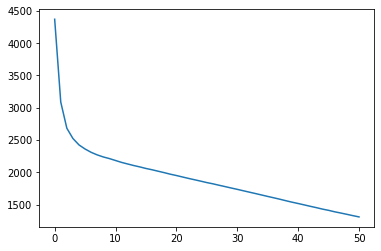

In [49]:
x_values = range(len(epoch_train_log))
plt.plot(x_values, epoch_train_log, label='Train_loss')

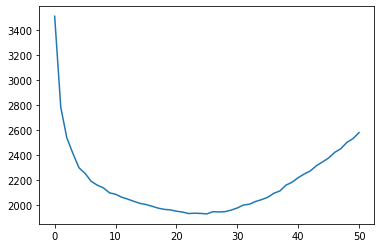

In [50]:
#epoch_val_log= [t.detach().cpu().numpy() for t in epoch_val_log]
x_values_val = range(len(epoch_val_log))
plt.plot(x_values_val, epoch_val_log, label='val_loss')

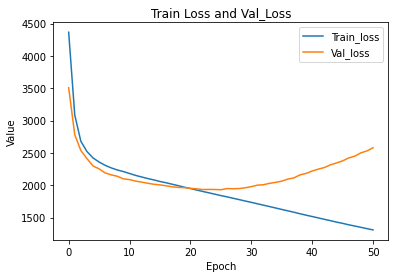

In [51]:
min_length = min(len(epoch_train_log), len(epoch_val_log))
list1 = epoch_train_log[:min_length]
list2 = epoch_val_log[:min_length]

# Create x-axis values
x_values = range(min_length)

# Plot the lists
plt.plot(x_values, list1, label='Train_loss')
plt.plot(x_values, list2, label='Val_loss')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Train Loss and Val_Loss')
plt.legend()